In [1]:
import sys
from pathlib import Path
project_dir = Path.cwd().parent
print(project_dir)
sys.path.insert(1, Path(project_dir, "analysis").as_posix())
sys.path.insert(1, Path(project_dir, "filterlists").as_posix())
import check_tracking_single_url
import utilities
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import re
import urllib.parse
import os
import tldextract
import tld
from urllib.parse import urlparse
from tqdm import tqdm
import ast

/home/pooneh/cookieProtect/cookieInterceptor


In [2]:
def get_domain_name(url, root_url):
    if not check_tracking_single_url.is_ulr_valid(url):
        return root_url
    top_domain = tld.get_fld(url)
    domain_name = '.'.join(top_domain.split('.')[-2:])
    return domain_name

def get_domain(url):
    try:
        u = tldextract.extract(url)
        return u.domain + "." + u.suffix
    except Exception as e:
        print(e)
        return ''

def get_schemeless_url(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc.split('www.')[-1]
    path = parsed_url.path
    query = parsed_url.query

    # Reconstruct the desired part
    desired_part = f"{domain}{path}?{query}"
    return desired_part
    
def is_3p(url1, url2):
    is_3p = check_tracking_single_url.get_domain(url1) != check_tracking_single_url.get_domain(url2)
    return is_3p
    
def direct_or_indirect(site, url):
    for u in inclusion_level[site]["direct"]:
        if u == url:
            return "direct"
    for u in inclusion_level[site]["indirect"]:
        if u == url:
            return "indirect"
    return None

In [2]:
# Load Data
output = Path(project_dir, "analyze/data/post_analysis")
# load Data
storage_dict_dir = Path(project_dir, "analyze/data/storage_dict.json")
storage_dict = utilities.read_json(storage_dict_dir)

In [4]:
# load direct_indorect scripts
dir = Path(project_dir, "analysis/data/subsequentScripts")
inclusion_level = utilities.read_json(Path(dir, 'inclusion_level.json'))

In [9]:
sites = 0
all_crawled_sites_dir = Path(project_dir, "server/output")
all_crawled_sites = utilities.get_directories_in_a_directory(all_crawled_sites_dir)
for site in all_crawled_sites:
    num_files = len(utilities.get_files_in_a_directory(site))
    if num_files >= 1:
        sites += 1
print(sites)

2537


In [11]:
storage_dict['google.com']

KeyError: 'google.com'

## General stats of cookie setting

In [14]:
# total unique cookies, i.e. (cookie_name, owner domain, site_name)
unique_cookies = set()
unique_owners = set()
for site, storage in storage_dict.items():
    for cookie_name, info in storage.items():
        owner_url = check_tracking_single_url.url_polisher(info['owner']['initiatorURL'], site)
        unique_owners.add(get_schemeless_url(owner_url))
        if check_tracking_single_url.is_ulr_valid(owner_url):
            owner_domain = get_domain_name(owner_url,site)
        else:
            owner_domain = site
        unique_cookies.add((cookie_name, owner_domain, site))
print(len(unique_cookies))

71


In [15]:
# unique scripts set cookie
print(len(unique_owners))

67


In [17]:
unique_cookies

{('CTK', 'indeed.com', 'indeed.com'),
 ('_adm-gpp', 'tranquilveranda.com', 'fastcompany.com'),
 ('_awl', 'acidpigs.com', 'cnbc.com'),
 ('_awl', 'analyzecorona.com', 'pokemoncentral.it'),
 ('_awl', 'aspentimes.com', 'aspentimes.com'),
 ('_awl', 'chessbranch.com', 'christianity.com'),
 ('_awl', 'cwtv.com', 'cwtv.com'),
 ('_awl', 'driftingchef.com', 'co.uk'),
 ('_awl', 'enterdrama.com', 'blu-ray.com'),
 ('_awl', 'forevergears.com', 'popmatters.com'),
 ('_awl', 'frugalfiestas.com', 'cnet.com'),
 ('_awl', 'gladysway.com', 'goal.com'),
 ('_awl', 'handsomelythumb.com', 'kcra.com'),
 ('_awl', 'hospitablehall.com', 'wgrz.com'),
 ('_awl', 'hospitablehall.com', 'whas11.com'),
 ('_awl', 'kidpowers.com', 'apnews.com'),
 ('_awl', 'kidpowers.com', 'genius.com'),
 ('_awl', 'luminousboulevard.com', 'vox.com'),
 ('_awl', 'marketwatch.com', 'marketwatch.com'),
 ('_awl', 'muteknife.com', 'technical.city'),
 ('_awl', 'nondescriptnote.com', 'nbcnews.com'),
 ('_awl', 'opulentsylvan.com', 'closerweekly.com'),

In [18]:
# On average how many 3P scripts sets how many unique cookies on websites
avg = {}
for site, storage in storage_dict.items():
    for cookie_name, info in storage.items():
        owner_raw_url = info['owner']['script_url']
        owner_schemeless_url = get_schemeless_url(owner_raw_url)
        if is_3p(owner_schemeless_url, site):
            if site not in avg:
                avg[site] = {'scripts': set(), 'cookies': set()}
            avg[site]['scripts'].add(owner_schemeless_url)
            avg[site]['cookies'].add(cookie_name)
scripts = []
cookies = []
for site, info in avg.items():
    scripts.append(len(info['scripts']))
    cookies.append(len(info['cookies']))
print("average scripts: ", sum(scripts) / len(scripts))
print("average cookies: ", sum(cookies) / len(cookies))

KeyError: 'script_url'

In [20]:
# On average how many 1P scripts sets how many unique cookies on websites
avg = {}
for site, storage in storage_dict.items():
    for cookie_name, info in storage.items():
        owner_raw_url = info['owner']['initiatorURL']
        owner_schemeless_url = get_schemeless_url(owner_raw_url)
        if not is_3p(owner_schemeless_url, site):
            if site not in avg:
                avg[site] = {'scripts': set(), 'cookies': set()}
            avg[site]['scripts'].add(owner_schemeless_url)
            avg[site]['cookies'].add(cookie_name)
scripts = []
cookies = []
for site, info in avg.items():
    scripts.append(len(info['scripts']))
    cookies.append(len(info['cookies']))
print("average scripts: ", sum(scripts) / len(scripts))
print("average cookies: ", sum(cookies) / len(cookies))

average scripts:  1.0416666666666667
average cookies:  1.0416666666666667


In [21]:
# Which sites sets the most number of scripts
max_cookie = 0
max_site = ""
for site, info in avg.items():
    if max_cookie < len(info):
        max_cookie = len(info)
        max_site = site
print(max_site, max_cookie)

worldofbooks.com 2


In [9]:
filterlist_dir = Path.home().joinpath(project_dir, "filterlists/data/filterlists")
filterlists = os.listdir(filterlist_dir)

# # filter rules
filterlist_rule_dir = Path.home().joinpath(project_dir, "filterlists/data/filterlist_rules.pkl")
filterlist_rules = pd.read_pickle(filterlist_rule_dir)

In [11]:
# For instance, \url{clover.com} deploys a remarkable 20 different external scripts 
# (17 of which are categorized as third-party tracking scripts) to set 83 unique cookies.
third_party = 0
tracking = 0
for script in avg['clover.com']['scripts']:
    if is_3p(script, 'clover.com'):
        third_party += 1
        if check_tracking_single_url.is_tracking(script, 'clover.com', filterlists, filterlist_rules):
            tracking += 1
tracking

TypeError: is_ulr_valid() takes 1 positional argument but 2 were given

In [22]:
# what percent of cookie owners does not beling to direct/indirect (None)
count = 0
total  = 0
for site, storage in storage_dict.items():
    for cookie_name, info in storage.items():
        total += 1
        owner_raw_url = info['owner']['initiatorURL']
        owner_schemeless_url = get_schemeless_url(owner_raw_url)
        if not direct_or_indirect(site, owner_schemeless_url):
            count += 1
print(count / len(unique_cookies))
print(count, len(unique_cookies))

NameError: name 'inclusion_level' is not defined

In [24]:
# what percent of cookie owners are invalid urls
invalid = 0
total = 0
for site, storage in storage_dict.items():
    for cookie_name, info in storage.items():
        total += 1
        owner_raw_url = info['owner']['initiatorURL']
        owner_domain = get_domain_name(owner_raw_url, site)
        if owner_domain == 'invalid':
            invalid +=1
print(invalid/len(unique_cookies))
print(invalid,len(unique_cookies))

0.0
0 71


In [57]:
# what percent of cookies are set by third-party scripts
# what percent of them is direct and what percent is indirect
third_party = {'direct': 0, 'indirect':0}
first_party = {'direct': 0, 'indirect':0}
total = 0
invalid = 0
thirdp = 0
firstp = 0
for site, storage in storage_dict.items():
    for cookie_name, info in storage['cookie'].items():
        total += 1
        owner_raw_url = info['owner']['script_info']['script_url']
        owner_domain = get_domain_name(owner_raw_url, site)
        owner_schemeless_url = get_schemeless_url(owner_raw_url)
        # print("url:", owner_schemeless_url, "domain:", owner_domain, "site:", site)
        inclusion = direct_or_indirect(site, owner_schemeless_url)
        if inclusion:
            if is_3p(site, owner_domain):
                third_party[inclusion] += 1
                thirdp += 1
            else:
                first_party[inclusion] += 1
                firstp += 1
        else:
            invalid+=1
print(total, invalid)
print(thirdp, firstp)

107278 5255
93890 8133


In [ ]:
thirdp+firstp+invalid

In [ ]:
third_party

In [ ]:
first_party

In [ ]:
# what percent of cookies are ghost cookies?
round((third_party['direct']+third_party['indirect']) / (thirdp+firstp) * 100, 2)

In [ ]:
# what percent of ghoast cookies were set by indiretcly incuded scripts
round(third_party['indirect'] / thirdp * 100, 2)

## Prevalence of each action

In [26]:
manipulation = {}
for site, storage in storage_dict.items():
    manipulation[site] = {'retrieving': 0, 'StorageSet':0, 'deleting':0}
    reread = 0
    rewrite = 0
    delete = 0
    for cookie_name, info in storage.items():
        if len(info['logs']) > 0:
            for log in info['logs']:
                if log['action'] == 'retrieving':
                    reread+=1
                if log['action'] == 'overwriting':
                    rewrite += 1
                if log['action'] == 'deleting':
                    delete += 1
    if reread > 0:
        manipulation[site]['retrieving'] += 1
    if rewrite > 0:
        manipulation[site]['StorageSet'] += 1
    if delete > 0:
        manipulation[site]['deleting'] += 1
        
                
reread = 0
rewrite = 0
delete = 0
for site, info in manipulation.items():
    reread += info['retrieving']
    rewrite += info['StorageSet']
    delete += info['deleting']

print("Storage retrieving: ", reread / len(storage_dict.keys()))
print("Storage overwriting: ", rewrite / len(storage_dict.keys()))
print("Storage deleting: ", delete / len(storage_dict.keys()))

Storage retrieving:  0.546875
Storage StorageSet:  0.0
Storage deleting:  0.0


In [27]:
manipulation

{'closerweekly.com': {'retrieving': 1, 'StorageSet': 0, 'deleting': 0},
 'worldofbooks.com': {'retrieving': 0, 'StorageSet': 0, 'deleting': 0},
 'miro.com': {'retrieving': 0, 'StorageSet': 0, 'deleting': 0},
 'indeed.com': {'retrieving': 0, 'StorageSet': 0, 'deleting': 0},
 'elizabetharden.com': {'retrieving': 0, 'StorageSet': 0, 'deleting': 0},
 'golinuxcloud.com': {'retrieving': 1, 'StorageSet': 0, 'deleting': 0},
 'zdnet.com': {'retrieving': 1, 'StorageSet': 0, 'deleting': 0},
 'humankinetics.com': {'retrieving': 0, 'StorageSet': 0, 'deleting': 0},
 'wbrc.com': {'retrieving': 1, 'StorageSet': 0, 'deleting': 0},
 'aloyoga.com': {'retrieving': 0, 'StorageSet': 0, 'deleting': 0},
 'popmatters.com': {'retrieving': 1, 'StorageSet': 0, 'deleting': 0},
 'genius.com': {'retrieving': 1, 'StorageSet': 0, 'deleting': 0},
 'whas11.com': {'retrieving': 1, 'StorageSet': 0, 'deleting': 0},
 'cnet.com': {'retrieving': 1, 'StorageSet': 0, 'deleting': 0},
 'tvline.com': {'retrieving': 1, 'StorageSet'

In [30]:
exfiltration = {}
for site, storage in storage_dict.items():
    exfiltration[site] = 0
    ex = 0
    for cookie_name, info in storage.items():
        for log in info['logs']:
            if log['action'] == 'exfiltration':
        # if len(info['exfiltration']) > 0:
                exfiltration[site] += 1
                break
count = 0
for site, val in exfiltration.items():
    if val > 0:
        count += 1
count / len(storage_dict.keys())

0.5

In [37]:
# what percent of cookies are undergone a change:
# find total number of cookies on 10k websites
num_all_cookies = 0
all_cookies = set()
num_StorageSet = 0
num_StorageReadResult = 0
num_DeleteStorage = 0
num_Exfiltration = 0
for site, storage in storage_dict.items():
    num_all_cookies += len(storage.keys())
    # count the number of each action on a cookie. Count each action only once

    for cookie_name, info in storage.items():
        StorageSet = 0
        StorageReadResult = 0
        DeleteStorage = 0
        Exfiltration = 0
        # count cross-domain reading, writing, and deleting
        for log in info['logs']:
            if log['action'] == 'overwriting':
                StorageSet += 1
            if log['action'] == 'retrieving':
                StorageReadResult += 1
            if log['action'] == 'deleting':
                DeleteStorage += 1
        # if at least one action has happened, count it once
        if StorageSet > 0:
            num_StorageSet += 1
        if StorageReadResult > 0:
            num_StorageReadResult += 1
        if DeleteStorage > 0:
            num_DeleteStorage += 1
            
        # count cross-domain exfiltration
        for log in info['logs']:
            if log['action'] == 'exfiltration':
                num_Exfiltration += 1
                break
            
print(num_all_cookies, num_StorageSet, num_StorageReadResult, num_DeleteStorage, num_Exfiltration)

print("All cookies accross 10k sites: ", num_all_cookies)
print("% of overwriting: ", round((num_StorageSet/num_all_cookies*100),2), "%")
print("% of storage reading: ", round((num_StorageReadResult/num_all_cookies*100),2), "%")
print("% of storage deleting: ", round((num_DeleteStorage/num_all_cookies*100),2), "%")
print("% of storage exfiltration: ", round((num_Exfiltration/num_all_cookies*100),2), "%")

71 0 42 0 33
All cookies accross 10k sites:  71
% of overwriting:  0.0 %
% of storage reading:  59.15 %
% of storage deleting:  0.0 %
% of storage exfiltration:  46.48 %


In [7]:
# Actions on each key
"""
what differrent actions happen on keys by which party.
Get the storage_dict and create a dataframe providing information about what actions happens on each key of each storage
"""
a = {}

for site, cookies in storage_dict.items():
    a[site] = {}
    for key, info in cookies.items():
        a[site][key] = {}
        logs = info.get('logs', [])
        owner_url = info['owner']['initiatorURL']
        
        for log in logs:
            action = log.get('action')
            initiatorURL = log.get('initiatorURL')
            
            if action != 'exfiltration':
                if action not in a[site][key]:
                    a[site][key][action] = {}
                if initiatorURL not in a[site][key][action]:
                    a[site][key][action][initiatorURL] = {
                        'attacker_url': initiatorURL,
                        'ownerURL': owner_url,
                        'value': log.get('value'),
                        'freq': 0,
                        'is_owner': initiatorURL == owner_url
                    }
                a[site][key][action][initiatorURL]['freq'] += 1

            else:  # handle exfiltration
                if 'exfiltration' not in a[site][key]:
                    a[site][key]['exfiltration'] = {}
                if initiatorURL not in a[site][key]['exfiltration']:
                    a[site][key]['exfiltration'][initiatorURL] = {
                        'freq': 0,
                        'owner': owner_url,
                        'modifier': initiatorURL,
                        'requested_url': log.get('destination'),
                        'identifiers': log.get('identifiers', []),
                        'is_owner': initiatorURL == owner_url
                    }
                a[site][key]['exfiltration'][initiatorURL]['freq'] += 1
                        
utilities.write_json(Path(output, "num_actions_on_keys.json"), a)

# Create number of actions on storage type per site

In [4]:
# reading the base dataframe
# record the number of rewriting, rereading, exfiltrating, and deleting another parties storage
num_actions_on_keys = utilities.read_json(Path(output, "num_actions_on_keys.json"))

actions = ['retrieving', 'deleting', 'overwriting', 'exfiltration']

for action_type in actions:
    action_dict = {}
    for site, cookieInfo in num_actions_on_keys.items():
        action_dict[site] = {}
        # for storage, meta in storages.items():
        #     action_dict[site][storage] = 0
            for key, info in cookieInfo.items():
                if action_type in info:
                    for script_id, log in info[action_type].items():
                        if not log['is_owner']:
                            action_dict[site][storage] += log['freq']
    utilities.write_json(Path.home().joinpath(output, action_type, action_type+"_nums.json"), action_dict)

# Create victim of actions dataframes

In [ ]:
# find "victims" of modification: {'(key, owner)': {'attacker': set(sites)}, 'num_attackers': len(attackers)}
# granuality : JS

actions = ['StorageSet', 'DeleteStorage', 'StorageReadResult', 'exfiltration']
# make directories per action

# reading base dataframe
num_actions_on_keys = utilities.read_json(Path(output, "num_actions_on_keys.json"))

for action in actions:
    modif_num_dict = utilities.read_json(Path.home().joinpath(output, action, action+"_nums.json"))
    victim_js = {'cookie': {}, 'session_storage': {}, 'local_storage': {}}
    for site, storages in num_actions_on_keys.items():
        for storage_type in storages:
            if modif_num_dict[site][storage_type] > 0:
                 for key in storages[storage_type]:  
                    if action in storages[storage_type][key]:
                        for script_id, log in storages[storage_type][key][action].items():
                            if action == "exfiltration":
                                # get owner url
                                owner = ""
                                if log['owner']['script_url']:
                                    url_parsed = urlparse(log['owner']['script_url'])
                                    owner = url_parsed.scheme+"://"+url_parsed.netloc+url_parsed.path
                                # get attacker info
                                atacker = ""
                                if log['modifier']['script_url']:
                                    url_parsed = urlparse(log['modifier']['script_url'])
                                    attacker = url_parsed.scheme+"://"+url_parsed.netloc+url_parsed.path
                                
                                if owner and attacker:
                                    if str((key, owner)) not in victim_js[storage_type]:
                                        victim_js[storage_type][str((key, owner))] = {'num_attacker': 0, 'attackers': {}}
                                    if attacker not in victim_js[storage_type][str((key, owner))]['attackers']:
                                        victim_js[storage_type][str((key, owner))]['attackers'][attacker] = set()
                                    victim_js[storage_type][str((key, owner))]['attackers'][attacker].add(site)
                                    victim_js[storage_type][str((key, owner))]['num_attacker'] = len(victim_js[storage_type][str((key, owner))]['attackers'])    
                            else:
                                if len(storages[storage_type][key][action]) > 1:
                                    # get owner url
                                    if log['is_owner']:  
                                        owner = ""
                                        if log['script_info']['script_url']:
                                            url_parsed = urlparse(log['script_info']['script_url'])
                                            owner = url_parsed.scheme+"://"+url_parsed.netloc+url_parsed.path
                                            continue
                                    # get attacker info
                                    else:
                                        atacker = ""
                                        if log['script_info']['script_url']:
                                            url_parsed = urlparse(log['script_info']['script_url'])
                                            attacker = url_parsed.scheme+"://"+url_parsed.netloc+url_parsed.path
                                    
                                    if owner and attacker:
                                        if str((key, owner)) not in victim_js[storage_type]:
                                            victim_js[storage_type][str((key, owner))] = {'num_attacker': 0, 'attackers': {}}
                                        if attacker not in victim_js[storage_type][str((key, owner))]['attackers']:
                                            victim_js[storage_type][str((key, owner))]['attackers'][attacker] = set()
                                        victim_js[storage_type][str((key, owner))]['attackers'][attacker].add(site)
                                        victim_js[storage_type][str((key, owner))]['num_attacker'] = len(victim_js[storage_type][str((key, owner))]['attackers'])    
                                else:
                                    continue
    #sort 
    sorted_data = {}
    for storage, value in victim_js.items():
        sorted_data[storage] = dict(sorted(value.items(), key=lambda x: x[1]['num_attacker'], reverse=True))
    # convert set to list    
    for storage, info in sorted_data.items():
        for key, value in info .items():
            value['attackers'] = dict(sorted(value["attackers"].items(), key=lambda x: len(x[1]), reverse=True))
            for attacker in sorted_data[storage][key]['attackers']:
                sorted_data[storage][key]['attackers'][attacker] = list(sorted_data[storage][key]['attackers'][attacker])
                
    utilities.write_json(Path.home().joinpath(output, action, "victim_js.json"), sorted_data)                                         

In [38]:
# plots of top manipulators and exfiltrators
# X-axis show the list of top domains and y-axis shows the percent of manipulation/ exfiltration
def get_domain(url):
    if not url.startswith('http'):
        url = "https://" + url
    if not check_tracking_single_url.is_ulr_valid(url):
        return url
    domain_name = tldextract.extract(url).domain+"."+tldextract.extract(url).suffix
    # top_domain = tld.get_fld(url)
    # domain_name = '.'.join(top_domain.split('.')[-2:])
    return domain_name
    
def bar_plot_attackers(domains, percentages, attack_type, output):    
    # Creating the bar plot
    plt.figure(figsize=(3,4))
    plt.bar(domains, percentages, color='black', width=0.5)
    plt.xlabel(attack_type)
    plt.ylabel('percentage')
    # plt.title('Percentage Distribution Across Domains')
    
    # Rotating the domain names vertically
    plt.xticks(rotation=90)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)

    
    # Display the plot
    plt.tight_layout()
    plt.savefig(Path(output, 'top_attacker.pdf'))
    plt.show()
    
    
def attacker_data_preparer(attacker_path, num_attacks, attack_type):
    output_fig = attacker_path.parent
    attacker_host = utilities.read_json(attacker_path)
    attacker_domains = []
    attacker_freq = []
    for attacker, info in attacker_host['cookie'].items():
        domain_name = get_domain(attacker)
        attacker_domains.append(domain_name)
        attacker_freq.append(round(info['num_victims']/num_attacks*100,2))
    print(attacker_domains)
    print(attacker_freq)
    bar_plot_attackers(attacker_domains[:11], attacker_freq[:11], attack_type, output_fig)

In [39]:
# exfiltrators:
attacker_exfiltrator_path = Path(project_dir, 'analysis/data/cookies/post_analysis/exfiltration/attacker_host.json')
attacker_data_preparer(attacker_exfiltrator_path, num_Exfiltration, 'cookie exfiltrators')

FileNotFoundError: [Errno 2] No such file or directory: '/home/pooneh/cookieProtect/cookieInterceptor/analysis/data/cookies/post_analysis/exfiltration/attacker_host.json'

['pubmatic.com', 'criteo.net', 'indiatimes.com', 'tiqcdn.com', 'osano.com', 'googletagmanager.com', 'google-analytics.com', 'crwdcntrl.net', 'visualwebsiteoptimizer.com', 'freshworks.com', 'rubiconproject.com', 'jpmorgan.com', 'connatix.com', 'ezodn.com', 'cxense.com', 'dotomi.com', 'https://ibxolb', 'segment.com', 'bbci.co.uk', 'primis.tech', 'azure.com', 'optimizely.com', 'doubleclick.net', 'geniee.jp', 'newsobserver.com', 'adobedtm.com', 'amplitude.com', 'clearbitjs.com', 'googlesyndication.com', 'googleapis.com', 'aticdn.net', 'tinypass.com', 'rocketnews24.com', 'rudderlabs.com', 'adtelligent.com', 'spolecznosci.net', 'adpushup.com', 'pub.network', 'px-cloud.net', 'piano.io', 'cio.com', 'pixfuture.com', 'lngtdv.com', 'ketchjs.com', 'hitc.com', 'sp-prod.net', 'cloudfront.net', 'intergi.com', 'vlitag.com', 'infoworld.com', 'ocdn.eu', 'csoonline.com', 'networkworld.com', 'adtcdn.com', 'optad360.io', 'facebook.net', 'h12-media.com', 'msecnd.net', 'wpadmngr.com', 'cake017.ru', 'outbrain

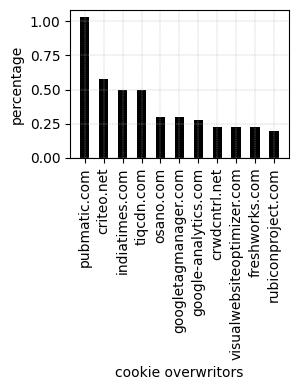

In [49]:
#overwriters
attacker_overwriter_path = Path(project_dir, 'analysis/data/cookies/post_analysis/StorageSet/attacker_host.json')
attacker_data_preparer(attacker_overwriter_path, num_StorageSet, 'cookie overwritors')

['google-analytics.com', 'googletagmanager.com', 'facebook.net', 'doubleclick.net', 'cookielaw.org', 'licdn.com', 'google.com', 'hotjar.com', 'amazon-adsystem.com', 'ads-twitter.com', 'bing.com', 'googlesyndication.com', 'crwdcntrl.net', 'criteo.net', 'quantserve.com', 'clarity.ms', 'scorecardresearch.com', 'fastclick.net', 'chartbeat.com', 'tiktok.com', 'go-mpulse.net', 'yandex.ru', 'taboola.com', 'adobedtm.com', 'marketo.net', 'googleoptimize.com', 'google.com', 'hs-analytics.net', 'baidu.com', 'pubmatic.com', 'googletagservices.com', 'redditstatic.com', 'id5-sync.com', 'hs-banner.com', '6sc.co', 'sc-static.net', 'pinimg.com', 'rlcdn.com', 'crazyegg.com', 'parsely.com', 'ad.gt', 'tiqcdn.com', 'googleapis.com', 'gstatic.com', 'hsleadflows.net', 'jsdelivr.net', 'segment.com', 'cxense.com', 'driftt.com', 'yimg.com', 'civiccomputing.com', 'mrf.io', 'googleadservices.com', 'stackadapt.com', 'qualtrics.com', 'privacy-center.org', 'amplitude.com', 'im-apps.net', 'google-analytics.com', 'imr

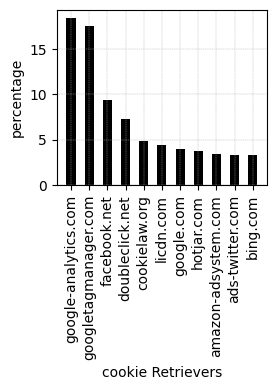

In [68]:
#re-reader
attacker_rereader_path = Path(project_dir, 'analysis/data/cookies/post_analysis/StorageReadResult/attacker_host.json')
attacker_data_preparer(attacker_rereader_path, num_StorageReadResult, 'cookie Retrievers')

['civiccomputing.com', 'cookie-script.com', 'databricks.com', 'id5-sync.com', 'prensaiberica.es', 'mxpnl.com', 'unipd.it', 'cxense.com', 'cookie-script.com', 'amazonaws.com', 'ucl.ac.uk', 'gazeta.pl', 'adobedtm.com', 'tiqcdn.com', 'dmca.com', 'cdn-cookieyes.com', 'washingtonpost.com', 'transcend.io', 'aticdn.net', 'tinypass.com', 'truyo.com', 'ulisboa.pt', 'illow.io', 'doubleclick.net', 'piano.io', 'kiwi.com', 'aade.gr', 'gatech.edu', 'ex.co', 'osano.com', 'cloverstatic.com', 'onswingers.net', 'ru.nl', 'cookie-script.com', 'qub.ac.uk', 'hpe.com', 'segment.com', 'googlesyndication.com', 'trustcommander.net', 'webgo.de', 'skypeassets.com', 'yandex.ru', 'fox.com', 'barclaycardus.com', 'crwdcntrl.net', 'segment.io', 'koala.live', 'pranmcpkx.com', 'googleapis.com', 'czx5eyk0exbhwp43ya.biz', 'jamieoliver.com', 'omappapi.com', 'sindonews.tv', 'jsdelivr.net', 'treasuredata.com', 'newsobserver.com', '360.cn', 'toyokeizai.net', 'infolinks.com', 'piano.io', 'quantserve.com', 'bathandbodyworks.com

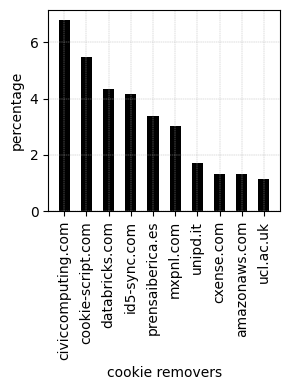

In [72]:
# deleter
attacker_deleter_path = Path(project_dir, 'analysis/data/cookies/post_analysis/DeleteStorage/attacker_host.json')
attacker_data_preparer(attacker_deleter_path, num_DeleteStorage, 'cookie removers')

In [42]:
a

{'closerweekly.com': {'_awl': {'retrieving': {'closerweekly.com/': {'initiatorURL': 'closerweekly.com/',
     'value': '',
     'freq': 1,
     'is_owner': False}},
   'exfiltration': {'googletagmanager.com/gtag/js?id=G-N5N9ZZ5Q2K&l=dataLayer&cx=c&gtm=45He5521v830013183za200&tag_exp=101509156~103101750~103101752~103116025~103200001~103231718~103231720~103233424~103251618~103251620~103252644~103252646': {'freq': 2,
     'owner': 'https://marketwatch.com/:96:18180)',
     'modifier': 'googletagmanager.com/gtag/js?id=G-N5N9ZZ5Q2K&l=dataLayer&cx=c&gtm=45He5521v830013183za200&tag_exp=101509156~103101750~103101752~103116025~103200001~103231718~103231720~103233424~103251618~103251620~103252644~103252646',
     'requested_url': 'https://analytics.google.com/g/collect?v=2&tid=G-N5N9ZZ5Q2K&gtm=45je5521v876326923z8830013183za200zb830013183&_p=1746498623421&_gaz=1&gcd=13l3l3l3l1l1&npa=0&dma=0&tag_exp=101509156~103101750~103101752~103116025~103200001~103231718~103231720~103233424~103251618~10325162

## Prevalence of actions per script type

### SorageSet

In [ ]:
all_scripts_dir = Path.home().joinpath(project_dir, "analysis/data/cookies/all_scripts_analysis")
nums_per_script_type = utilities.read_json(Path.home().joinpath(all_scripts_dir, "StorageSet", "StorageSet_nums_per_script_type.json"))

nums_script_type = {'cookie': {}, 'local_storage': {}, 'session_storage': {}}
for site, meta in nums_per_script_type.items():
    for storage, info in meta.items():
        for script_type in info:
            if script_type not in nums_script_type[storage]:
                nums_script_type[storage][script_type] = 0
            nums_script_type[storage][script_type] += info[script_type]
nums_script_type           

## exfiltration

In [ ]:
all_scripts_dir = Path.home().joinpath(project_dir, "analysis/data/cookies/all_scripts_analysis")
nums_per_script_type = utilities.read_json(Path.home().joinpath(all_scripts_dir, "exfiltration", "exfiltration_nums_per_script_type.json"))

nums_script_type = {'cookie': {}, 'local_storage': {}, 'session_storage': {}}
for site, meta in nums_per_script_type.items():
    for storage, info in meta.items():
        for script_type in info:
            if script_type not in nums_script_type[storage]:
                nums_script_type[storage][script_type] = 0
            nums_script_type[storage][script_type] += info[script_type]
nums_script_type           

### StorageReadResult

In [ ]:
all_scripts_dir = Path.home().joinpath(project_dir, "analysis/data/top_10k/cookies/all_scripts_analysis")
nums_per_script_type = utilities.read_json(Path.home().joinpath(all_scripts_dir, "StorageReadResult", "StorageReadResult_nums_per_script_type.json"))

nums_script_type = {'cookie': {}, 'local_storage': {}, 'session_storage': {}}
for site, meta in nums_per_script_type.items():
    for storage, info in meta.items():
        for script_type in info:
            if script_type not in nums_script_type[storage]:
                nums_script_type[storage][script_type] = 0
            nums_script_type[storage][script_type] += info[script_type]
nums_script_type           

### DeleteStorage

In [ ]:
all_scripts_dir = Path.home().joinpath(project_dir, "analysis/data/top_10k/cookies/all_scripts_analysis")
nums_per_script_type = utilities.read_json(Path.home().joinpath(all_scripts_dir, "DeleteStorage", "DeleteStorage_nums_per_script_type.json"))

nums_script_type = {'cookie': {}, 'local_storage': {}, 'session_storage': {}}
for site, meta in nums_per_script_type.items():
    for storage, info in meta.items():
        for script_type in info:
            if script_type not in nums_script_type[storage]:
                nums_script_type[storage][script_type] = 0
            nums_script_type[storage][script_type] += info[script_type]
nums_script_type           

##  box plot for the number of different storage types on 10k websites

In [ ]:
# create box plot for the number of different storage types on 10k websites

# create data
dict_storage_freq = utilities.read_json(Path.home().joinpath(output, "dict_storage_freq.json"))
data = {'cookie': [], 'local_storage': [], 'session_storage': []}

for site, storages in dict_storage_freq.items():
    if storages['cookie'] > 80:
        print(site, storages['cookie'])
    data['cookie'].append(storages['cookie'])    
    data['local_storage'].append(storages['local_storage'])
    data['session_storage'].append(storages['session_storage'])

values = list(data.values())

# make the plots
fig, ax = plt.subplots(figsize=(5, 4))


# Plot box properties
boxprops = dict(color='black', linewidth=1.5)
medianprops = dict(color='red', linewidth=2)
whiskerprops = dict(color='black', linewidth=1)
capprops = dict(color='black', linewidth=1)
flierprops = dict(marker='o', markersize=5, markerfacecolor='blue', markeredgecolor='black')

# Create the boxplot
ax.boxplot(values, boxprops=boxprops, 
                   medianprops=medianprops, 
                   whiskerprops=whiskerprops, 
                   capprops=capprops, 
                   flierprops=flierprops,
                   showfliers=False)

# Set the labels for the x-axis
ax.set_xticklabels(data.keys())

# # Calculate the mean

mean_storage = []
for value in values:
    mean_storage.append(mean(value))

# # Add mean marker
plt.scatter(range(1, len(mean_storage) + 1), mean_storage, marker='D', color='green', label='Mean')


# # Adding labels and title
# plt.xlabel('Storage type', fontsize=10)
plt.ylabel('# of unique storage names across sites', fontsize=10)
ax.set_xticklabels(data.keys())

# # Customize font size and style
plt.rcParams.update({'font.size': 10})

# # Adjust the aspect ratio
plt.gca().set_aspect('auto')

# # Add gridlines
ax.yaxis.grid(True, linestyle='--', color='lightgray', linewidth=0.5)

# # Increase spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Add legend
plt.legend(loc='upper right')

# Displaying the plot
plt.savefig(Path.home().joinpath(project_dir, "analysis/data/plots/unique_number_of_storage_names.pdf"), bbox_inches='tight')
plt.show()

## HEATMAP = > Storage Victims VS Attackers. 
Values per cell equal the number of sites they have've been observed modifying¶

In [ ]:
# geral function to plot a heatmap
leng = 20
def heatmap(action, storage_type, level):
    victims = utilities.read_json(Path.home().joinpath(output, action, "victim_"+level+".json"))
    top_victims = list(victims.keys())[:leng]   
    all_attackers = list(utilities.read_json(Path.home().joinpath(output, action, "attacker_"+level+".json")).keys())         
    top_attackers = []
    
    num_attackers = []
    for victim in top_victims:
        num_attackers.append(len(victims[victim]['attackers']))
        
        
    while len(top_attackers) < len(all_attackers[:leng]):
        for victim in list(victims.keys()):
            attackers = list(victims[victim]['attackers'].keys())
            if len(top_attackers) < leng:
                for attacker in attackers:
                    # att = attackers[idx]
                    if attacker not in top_attackers:
                        top_attackers.append(attacker)
                        break
            else:
                break
    
    matrix =  [[0 for j in range(len(top_attackers[:leng]))] for i in range(len(top_victims[:leng]))]
    for i in range(len(top_victims[:leng])):
        for j in range(len(top_attackers[:leng])):
            if top_attackers[j] in victims[top_victims[i]]['attackers']:
                matrix[i][j] = len(victims[top_victims[i]]['attackers'][top_attackers[j]])
            else:
                matrix[i][j] = 0

    if matrix: 
        normalized_matrix = [[cell / sum(row) if sum(row) != 0 else 0 for cell in row] for row in matrix]

        # plt.figure(figsize=(30, 30))
        fig, ax = plt.subplots(figsize=(10, 8))
        _cmap = 'plasma'
#         _cmap = plt.cm.YlOrBr
        im1 = ax.imshow(normalized_matrix, cmap=_cmap, alpha=.9)

        y_labels = top_victims
        x_labels = top_attackers
        plt.xticks(range(len(x_labels)), x_labels, rotation=90, fontsize=12)
        plt.yticks(range(len(y_labels)), y_labels, fontsize=12)
        plt.ylabel('(Storage name, Owner)', fontsize=16)
        plt.xlabel('Exfiltrators', fontsize=16)
        
        # Create a secondary y-axis (ax2)
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(np.arange(len(y_labels)))
        ax2.set_yticklabels(num_attackers, fontsize=12)
        
        # Adjust the position of the secondary y-axis
        ax2.spines['right'].set_position(('outward', 1))
        ax2.spines['right'].set_visible(True)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.set_ticks_position('right')
                
        cbar1 = fig.colorbar(im1, ax=ax)
        cbar1.ax.tick_params(labelsize=12)

        # show the plot 
        plt.savefig(Path.home().joinpath(project_dir, "analysis/data/plots/storage_analysis", action,'victim_vs_attacker', level+"_"+storage_type+".pdf"), bbox_inches='tight')
        
    else:
        print("This case is not available")

## StorageSet

### cookie

In [ ]:
### Analysis type: StorageSet
### storage-type: Cookie
### analysis Level: JavaScript

heatmap('StorageSet', 'cookie', 'js')

In [ ]:
### Analysis type: StorageSet
### storage-type: Cookie
### analysis Level: Host
heatmap('StorageSet', 'cookie', 'host')

In [ ]:
### Analysis type: StorageSet
### storage-type: Cookie
### analysis Level: Company
heatmap('StorageSet', 'cookie', 'company')

### local storage

In [ ]:
### Analysis type: StorageSet
### storage-type: local_storage
### analysis Level: JavaScript
heatmap('StorageSet', 'local_storage', 'js')

In [ ]:
### Analysis type: StorageSet
### storage-type: local_storage
### analysis Level: Host
heatmap('StorageSet', 'local_storage', 'host')

In [ ]:
### Analysis type: StorageSet
### storage-type: local_storage
### analysis Level: Company
heatmap('StorageSet', 'local_storage', 'company')

### session storage

In [ ]:
### Analysis type: StorageSet
### storage-type: session_storage
### analysis Level: JavaScript
heatmap('StorageSet', 'session_storage', 'js')

In [ ]:
### Analysis type: StorageSet
### storage-type: session_storage
### analysis Level: Host
heatmap('StorageSet', 'session_storage', 'host')

In [ ]:
### Analysis type: StorageSet
### storage-type: session_storage
### analysis Level: Company
heatmap('StorageSet', 'session_storage', 'company')

## Delete Storage

### cookie

In [ ]:
### Analysis type: DeleteStorage
### storage-type: Cookie
### analysis Level: JS
heatmap('DeleteStorage', 'cookie', 'js')

In [ ]:
### Analysis type: DeleteStorage
### storage-type: Cookie
### analysis Level: Host
heatmap('DeleteStorage', 'cookie', 'host')

In [ ]:
### Analysis type: DeleteStorage
### storage-type: Cookie
### analysis Level: Company
heatmap('DeleteStorage', 'cookie', 'company')

### local storage

In [ ]:
### Analysis type: DeleteStorage
### storage-type: local_storage
### analysis Level: JS
heatmap('DeleteStorage', 'local_storage', 'js')

In [ ]:
### Analysis type: DeleteStorage
### storage-type: local_storage
### analysis Level: Host
heatmap('DeleteStorage', 'local_storage', 'host')

In [ ]:
### Analysis type: DeleteStorage
### storage-type: local_storage
### analysis Level: Company
heatmap('DeleteStorage', 'local_storage', 'company')

### session storage

In [ ]:
### Analysis type: DeleteStorage
### storage-type: session_storage
### analysis Level: JS
heatmap('DeleteStorage', 'session_storage', 'js')

In [ ]:
### Analysis type: DeleteStorage
### storage-type: session_storage
### analysis Level: Host
heatmap('DeleteStorage', 'session_storage', 'host')

In [ ]:
### Analysis type: DeleteStorage
### storage-type: session_storage
### analysis Level: Company
heatmap('DeleteStorage', 'session_storage', 'company')

## Exfiltration

### cookie

In [ ]:
### Analysis type: exfiltration
### storage-type: Cookie
### analysis Level: JS
heatmap('exfiltration', 'cookie', 'js')

In [ ]:
### Analysis type: exfiltration
### storage-type: Cookie
### analysis Level: Host
heatmap('exfiltration', 'cookie', 'host')

In [ ]:
### Analysis type: exfiltration
### storage-type: Cookie
### analysis Level: Company
heatmap('exfiltration', 'cookie', 'company')

### local storage

In [ ]:
### Analysis type: exfiltration
### storage-type: local_storage
### analysis Level: JS
heatmap('exfiltration', 'local_storage', 'js')

In [ ]:
### Analysis type: exfiltration
### storage-type: local_storage
### analysis Level: Host
heatmap('exfiltration', 'local_storage', 'host')

In [ ]:
### Analysis type: exfiltration
### storage-type: local_storage
### analysis Level: Company
heatmap('exfiltration', 'local_storage', 'company')

### session storage

In [ ]:
### Analysis type: exfiltration
### storage-type: session_storage
### analysis Level: JS
heatmap('exfiltration', 'session_storage', 'js')

In [ ]:
### Analysis type: exfiltration
### storage-type: session_storage
### analysis Level: Host
heatmap('exfiltration', 'session_storage', 'host')

In [ ]:
### Analysis type: exfiltration
### storage-type: session_storage
### analysis Level: Company
heatmap('exfiltration', 'session_storage', 'company')

## StorageReadResult

### cookie

In [ ]:
### Analysis type: StorageReadResult
### storage-type: Cookie
### analysis Level: JS
heatmap('StorageReadResult', 'cookie', 'js')

In [ ]:
### Analysis type: StorageReadResult
### storage-type: Cookie
### analysis Level: Host
heatmap('StorageReadResult', 'cookie', 'host')

In [ ]:
### Analysis type: StorageReadResult
### storage-type: Cookie
### analysis Level: Company
heatmap('StorageReadResult', 'cookie', 'company')

### local storage

In [ ]:
### Analysis type: StorageReadResult
### storage-type: local_storage
### analysis Level: JS
heatmap('StorageReadResult', 'local_storage', 'js')

In [ ]:
### Analysis type: StorageReadResult
### storage-type: local_storage
### analysis Level: JS
heatmap('StorageReadResult', 'local_storage', 'js')

In [ ]:
### Analysis type: StorageReadResult
### storage-type: local_storage
### analysis Level: Company
heatmap('StorageReadResult', 'local_storage', 'company')

### session storage

In [ ]:
### Analysis type: StorageReadResult
### storage-type: session_storage
### analysis Level: JS
heatmap('StorageReadResult', 'session_storage', 'js')

In [ ]:
### Analysis type: StorageReadResult
### storage-type: session_storage
### analysis Level: Host
heatmap('StorageReadResult', 'session_storage', 'host')

In [ ]:
### Analysis type: StorageReadResult
### storage-type: session_storage
### analysis Level: Company
heatmap('StorageReadResult', 'session_storage', 'company')

## HEATMAP = > Exfiltrator VS Destination.
Values per cell equal the number of sites they have've been observed modifying¶

In [ ]:
# geral function to plot a heatmap
leng = 20
def heatmap_exfiltrator(storage_type, level):
    exfiltrators = utilities.read_json(Path.home().joinpath(output, 'exfiltration', "exfiltrator_dest_"+level+".json"))
    top_exfiltrators = list(exfiltrators.keys())[:leng]   
    top_destinations = []
    
    num_dsts = []
    for exfiltrator in top_exfiltrators:
        num_dsts.append(len(exfiltrators[exfiltrator]['dst']))
    
    while len(top_destinations) < leng:
        for exfiltrator in list(exfiltrators.keys()):
            dests = list(exfiltrators[exfiltrator]['dst'].keys())
            if len(top_destinations) < leng:
                for dst in dests:
                    if dst not in top_destinations:
                        top_destinations.append(dst)
                        break
            else:
                break
    
    matrix =  [[0 for j in range(leng)] for i in range(leng)]
    for i in range(leng):
        for j in range(leng):
            if top_destinations[j] in exfiltrators[top_exfiltrators[i]]['dst']:
                matrix[i][j] = exfiltrators[top_exfiltrators[i]]['dst'][top_destinations[j]]['num_sites']
            else:
                matrix[i][j] = 0

    # create a heat map of top js libraries
    
    # normalize the matrix
    # row_sums = [sum(row) for row in matrix]
    if matrix: 
        normalized_matrix = [[cell / sum(row) if sum(row) != 0 else 0 for cell in row] for row in matrix]

        # plt.figure(figsize=(30, 30))
        fig, ax = plt.subplots(figsize=(10, 8))
        _cmap = 'plasma'
#         _cmap = plt.cm.YlOrBr
        im1 = ax.imshow(normalized_matrix, cmap=_cmap, alpha=.9)

        y_labels = top_exfiltrators
        x_labels = top_destinations
        plt.xticks(range(len(x_labels)), x_labels, rotation=90, fontsize=12)
        plt.yticks(range(len(y_labels)), y_labels, fontsize=12)
        
        plt.ylabel('Exfiltrators', fontsize=16)
        plt.xlabel('Destination', fontsize=16)
        
        
        # Create a secondary y-axis (ax2)
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(np.arange(len(y_labels)))
        ax2.set_yticklabels(num_dsts, fontsize=12)
        
        # Adjust the position of the secondary y-axis
        ax2.spines['right'].set_position(('outward', 1))
        ax2.spines['right'].set_visible(True)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.set_ticks_position('right')
                
        cbar1 = fig.colorbar(im1, ax=ax)
        cbar1.ax.tick_params(labelsize=12)
        

        
        
        

        # show the plot 
        plt.savefig(Path.home().joinpath(project_dir, "analysis/data/plots/storage_analysis", 'exfiltration', 'exfiltrator_vs_destination', level+"_"+storage_type+".pdf"), bbox_inches='tight')
        plt.show()
    else:
        print("This case is not available")

## cookie

In [ ]:
heatmap_exfiltrator('cookie', 'js')

In [ ]:
heatmap_exfiltrator('cookie', 'host')

In [ ]:
heatmap_exfiltrator('cookie', 'company')

## local storage

In [ ]:
heatmap_exfiltrator('local_storage', 'js')

In [ ]:
heatmap_exfiltrator('local_storage', 'host')

In [ ]:
heatmap_exfiltrator('local_storage', 'company')

## session storage

In [ ]:
heatmap_exfiltrator('session_storage', 'js')

In [ ]:
heatmap_exfiltrator('session_storage', 'host')

In [ ]:
heatmap_exfiltrator('session_storage', 'company')

## HEATMAP: EXfiltrator VS Destination
company vs. company

In [ ]:
# geral function to plot a heatmap
leng = 20
def heatmap_exfiltrator_compnay(storage_type):
    exfiltrators = utilities.read_json(Path.home().joinpath(output, 'exfiltration', "exfiltrator_company_dest_company.json"))
    top_exfiltrators = list(exfiltrators.keys())[:leng]
    
    num_dsts = []
    for exfiltrator in top_exfiltrators:
        num_dsts.append(len(exfiltrators[exfiltrator]['dst']))
        
    top_destinations = []
    
    while len(top_destinations) < leng:
        for exfiltrator in list(exfiltrators.keys()):
#             print(exfiltrator)
            dests = list(exfiltrators[exfiltrator]['dst'].keys())
            if len(top_destinations) < leng:
                for dst in dests:
#                     # Exclude the same companies
#                     if dst != exfiltrator:
                        if dst not in top_destinations:
                            top_destinations.append(dst)
                            break
            else:
                break
    
    matrix =  [[0 for j in range(leng)] for i in range(leng)]
    for i in range(leng):
        for j in range(leng):
            if top_destinations[j] in exfiltrators[top_exfiltrators[i]]['dst']:
                matrix[i][j] = exfiltrators[top_exfiltrators[i]]['dst'][top_destinations[j]]['num_sites']
            else:
                matrix[i][j] = 0
    print(matrix[0][3])
    # create a heat map of top js libraries
    
    if matrix: 
        normalized_matrix = [[cell / sum(row) if sum(row) != 0 else 0 for cell in row] for row in matrix]
        print(normalized_matrix[0][3])
        # plt.figure(figsize=(30, 30))
        fig, ax = plt.subplots(figsize=(10, 8))
        _cmap = 'plasma'
#         _cmap = plt.cm.YlOrBr
        im1 = ax.imshow(normalized_matrix, cmap=_cmap, alpha=.9)
        
        
        y_labels = top_exfiltrators
        x_labels = top_destinations
        
        plt.xticks(range(len(x_labels)), x_labels, rotation=90, fontsize=12)
        plt.yticks(range(len(y_labels)), y_labels, fontsize=12)
        plt.xlabel('Top destinations', fontsize=16)
        plt.ylabel('Top Exfiltrators', fontsize=16)
        
        
        # Create a secondary y-axis (ax2)
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(np.arange(len(y_labels)))
        ax2.set_yticklabels(num_dsts, fontsize=12)
        
        # Adjust the position of the secondary y-axis
        ax2.spines['right'].set_position(('outward', 1))
        ax2.spines['right'].set_visible(True)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.set_ticks_position('right')
                
        cbar1 = fig.colorbar(im1, ax=ax)
        cbar1.ax.tick_params(labelsize=12)
                
        # show the plot 
        plt.savefig(Path.home().joinpath(project_dir, "analysis/data/plots/storage_analysis", 'exfiltration', 'exfiltrator_vs_destination', "company_vs_company"+"_"+storage_type+".pdf"), bbox_inches='tight')
        plt.show()
    else:
        print("This case is not available")

In [ ]:
heatmap_exfiltrator_compnay('cookie')

In [ ]:
heatmap_exfiltrator_compnay('local_storage')

In [ ]:
heatmap_exfiltrator_compnay('session_storage')

## HEATMAP: storage victims VS Destination

In [ ]:
# geral function to plot a heatmap
leng = 30
def heatmap_victim_dest(storage_type):
    victims = utilities.read_json(Path.home().joinpath(output, 'exfiltration', "victim_destination.json"))
    top_victims = list(victims.keys())[:leng]   
    top_destinations = []
    
    while len(top_destinations) < leng:
        for victim in list(victims.keys()):
            dests = list(victims[victim]['dests'].keys())
            if len(top_destinations) < leng:
                for dst in dests:
                    if dst not in top_destinations:
                        top_destinations.append(dst)
                        break
            else:
                break
    
    matrix =  [[0 for j in range(leng)] for i in range(leng)]
    for i in range(leng):
        for j in range(leng):
            if top_destinations[j] in victims[top_victims[i]]['dests']:
                matrix[i][j] = len(victims[top_victims[i]]['dests'][top_destinations[j]])
            else:
                matrix[i][j] = 0

    # create a heat map of top js libraries
    
    # normalize the matrix
    # row_sums = [sum(row) for row in matrix]
    if matrix: 
        normalized_matrix = [[cell / sum(row) if sum(row) != 0 else 0 for cell in row] for row in matrix]

        # plt.figure(figsize=(30, 30))
        fig, ax = plt.subplots(figsize=(8, 8))
        _cmap = 'plasma'
#         _cmap = plt.cm.YlOrBr
        im1 = ax.imshow(normalized_matrix, cmap=_cmap, alpha=.9)

        y_labels = top_victims
        x_labels = top_destinations
        
        plt.xticks(range(len(x_labels)), x_labels, rotation=90, fontsize=12)
        plt.yticks(range(len(y_labels)), y_labels, fontsize=12)

        cbar1 = fig.colorbar(im1, ax=ax, shrink=0.8)
        cbar1.ax.tick_params(labelsize=12)
        
        plt.xlabel('Top destinations')
        plt.ylabel('Top Cookies')
        # show the plot 
        plt.savefig(Path.home().joinpath(project_dir, "analysis/data/plots/storage_analysis", 'exfiltration', 'victim_vs_destination', storage_type+".pdf"), bbox_inches='tight')
        plt.show()
    else:
        print("This case is not available")

In [ ]:
heatmap_victim_dest('cookie')

In [ ]:
heatmap_victim_dest('local_storage')

In [ ]:
heatmap_victim_dest('session_storage')

# The cumulative distribution function (CDF)  of modifications of victim storage keys
Modifications include: rewriting, deleting, rereading, and exfiltrating

In [ ]:
## general CDF plot maker
def cdf(data):
    # Calculate the cumulative probability of each value
    cumulative_prob = np.cumsum(np.ones_like(data)) / len(data)
    fig, ax = plt.subplots(figsize=(2, 2), dpi=100)

    # Plot the CDF
    plt.plot(data,cumulative_prob, color='black')

    # Add labels and title
    plt.xlabel('Number of attacker', fontsize=9)
    plt.ylabel('CDF (across storage names)', fontsize=9)
    # 
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    # Display the plot
    plt.grid(linestyle='--')
#     plt.savefig(Path.home().joinpath(project_dir, "analysis/data/plots/cdf_tree_length.pdf"), bbox_inches='tight')
    plt.show()

## CDF of ReWriting

In [ ]:
victim_js_rewriting = utilities.read_json(Path.home().joinpath(output, 'StorageSet', "victim_js.json"))
data_rewriting = []
for key, value in victim_js_rewriting['cookie'].items():
    data_rewriting.append(value['num_attacker'])
data_rewriting = sorted(data_rewriting, reverse=False)
print("Number of cookie names being attacked: ", len(data_rewriting))
print(mean(data_rewriting))
cdf(data_rewriting)

In [ ]:
victim_js_rewriting = utilities.read_json(Path.home().joinpath(output, 'StorageSet', "victim_js.json"))
data_rewriting = []
for key, value in victim_js_rewriting['local_storage'].items():
    data_rewriting.append(value['num_attacker'])
data_rewriting = sorted(data_rewriting, reverse=False)    
print("Number of local storage names being attacked: ", len(data_rewriting))
print(mean(data_rewriting))
cdf(data_rewriting)

In [ ]:
victim_js_rewriting = utilities.read_json(Path.home().joinpath(output, 'StorageSet', "victim_js.json"))
data_rewriting = []
for key, value in victim_js_rewriting['session_storage'].items():
    data_rewriting.append(value['num_attacker'])
data_rewriting = sorted(data_rewriting, reverse=False)    
print("Number of session storage names being attacked: ", len(data_rewriting))
print(mean(data_rewriting))
cdf(data_rewriting)

## CDF of ReReading

In [ ]:
victim_js_rereading = utilities.read_json(Path.home().joinpath(output, 'StorageReadResult', "victim_js.json"))
data_rereading = []
for key, value in victim_js_rereading['cookie'].items():
    data_rereading.append(value['num_attacker'])
data_rereading = sorted(data_rereading, reverse=False)
print("Number of cookie names being attacked: ", len(data_rereading))
print(mean(data_rereading))
cdf(data_rereading)

In [ ]:
victim_js_rereading = utilities.read_json(Path.home().joinpath(output, 'StorageReadResult', "victim_js.json"))
data_rereading = []
for key, value in victim_js_rereading['local_storage'].items():
    data_rereading.append(value['num_attacker'])
data_rereading = sorted(data_rereading, reverse=False)
print("Number of local_storage names being attacked: ", len(data_rereading))
print(mean(data_rereading))
cdf(data_rereading)

In [ ]:
victim_js_rereading = utilities.read_json(Path.home().joinpath(output, 'StorageReadResult', "victim_js.json"))
data_rereading = []
for key, value in victim_js_rereading['session_storage'].items():
    data_rereading.append(value['num_attacker'])
data_rereading = sorted(data_rereading, reverse=False)
print("Number of session_storage names being attacked: ", len(data_rereading))
print(mean(data_rereading))
cdf(data_rereading)

## CDF of Deleting

In [ ]:
victim_js_deleting = utilities.read_json(Path.home().joinpath(output, 'DeleteStorage', "victim_js.json"))
data_deleting = []
for key, value in victim_js_deleting['cookie'].items():
    data_deleting.append(value['num_attacker'])
data_deleting = sorted(data_deleting, reverse=False)
print("Number of cookie names being attacked: ", len(data_deleting))
print(mean(data_deleting))
cdf(data_deleting)

In [ ]:
victim_js_deleting = utilities.read_json(Path.home().joinpath(output, 'DeleteStorage', "victim_js.json"))
data_deleting = []
for key, value in victim_js_deleting['local_storage'].items():
    data_deleting.append(value['num_attacker'])
data_deleting = sorted(data_deleting, reverse=False)
print("Number of local_storage names being attacked: ", len(data_deleting))
print(mean(data_deleting))
cdf(data_deleting)

In [ ]:
victim_js_deleting = utilities.read_json(Path.home().joinpath(output, 'DeleteStorage', "victim_js.json"))
data_deleting = []
for key, value in victim_js_deleting['session_storage'].items():
    data_deleting.append(value['num_attacker'])
data_deleting = sorted(data_deleting, reverse=False)
print("Number of session_storage names being attacked: ", len(data_deleting))
print(mean(data_deleting))
cdf(data_deleting)

## CDF of Exfiltrating

In [ ]:
victim_js_exfiltration = utilities.read_json(Path.home().joinpath(output, 'exfiltration', "victim_js.json"))
data_exfiltration = []
for key, value in victim_js_exfiltration['cookie'].items():
    data_exfiltration.append(value['num_attacker'])
data_exfiltration = sorted(data_exfiltration, reverse=False)
print("Number of cookie names being attacked: ", len(data_exfiltration))
print(mean(data_exfiltration))
cdf(data_exfiltration)

In [ ]:
victim_js_exfiltration = utilities.read_json(Path.home().joinpath(output, 'exfiltration', "victim_js.json"))
data_exfiltration = []
for key, value in victim_js_exfiltration['local_storage'].items():
    data_exfiltration.append(value['num_attacker'])
data_exfiltration = sorted(data_exfiltration, reverse=False)
print("Number of local_storage names being attacked: ", len(data_exfiltration))
print(mean(data_exfiltration))
cdf(data_exfiltration)

In [ ]:
victim_js_exfiltration = utilities.read_json(Path.home().joinpath(output, 'exfiltration', "victim_js.json"))
data_exfiltration = []
for key, value in victim_js_exfiltration['session_storage'].items():
    data_exfiltration.append(value['num_attacker'])
data_exfiltration = sorted(data_exfiltration, reverse=False)
print("Number of session_storage names being attacked: ", len(data_exfiltration))
print(mean(data_exfiltration))
cdf(data_exfiltration)

In [19]:
# what is the total number of storage_keys?
all_keys = utilities.read_json(Path.home().joinpath(output, 'all_keys.json'))
print("Total number of cookie names across all websites: ", len(all_keys['cookie']))
print("Total number of local_storage names across all websites: ", len(all_keys['local_storage']))
print("Total number of session_storage names across all websites: ", len(all_keys['session_storage']))

Total number of cookie names across all websites:  28821
Total number of local_storage names across all websites:  26109
Total number of session_storage names across all websites:  9312


In [ ]:
# what is the total number of key_owner pairs?
all_keys_owners = utilities.read_json(Path.home().joinpath(output, 'all_keys_owners.json'))
print("Total number of cookie key_owners across all websites: ", len(all_keys_owners['cookie']))
print("Total number of local_storage key_owners across all websites: ", len(all_keys_owners['local_storage']))
print("Total number of session_storage key_owners across all websites: ", len(all_keys_owners['session_storage']))

In [ ]:
# what is the total number of owners?
all_owners = utilities.read_json(Path.home().joinpath(output, 'all_owners.json'))
print("Total number of cookie owners across all websites: ", len(all_owners['cookie']))
print("Total number of local_storage owners across all websites: ", len(all_owners['local_storage']))
print("Total number of session_storage owners across all websites: ", len(all_owners['session_storage']))

In [ ]:
exfiltrators = utilities.read_json(Path.home().joinpath(output, 'exfiltration', "exfiltrator_company_dest_company.json"))
for storage, meta in exfiltrators.items():
    for company, value in meta.items():
        if storage == 'cookie':
            print(len(exfiltrators['cookie'][company]['dst']), company)

In [ ]:
exfiltrators = utilities.read_json(Path.home().joinpath(output, 'exfiltration', "exfiltrator_company_dest_company.json"))
count = 0
for storage, meta in exfiltrators.items():
    for company, value in meta.items():
        if storage == 'cookie':
            if(len(value['dst'])>1):
                for dst in value['dst']:
                    if company == dst:
                        count += 1
                    break
count / len(list(exfiltrators['cookie'].keys())) * 100

In [37]:
# storageSet victims
victim_file = utilities.read_json(Path(project_dir, 'analysis/data/cookies/post_analysis/StorageSet/victim_host.json'))
victims = []
num_attackers = []
observed_sites = []
ratio = []
for victim, info in victim_file['cookie'].items():
    victim = ast.literal_eval(victim)
    cookie_name = victim[0]
    owner_host = victim[1]
    owner_domain = get_domain(owner_host)
    victims.append((cookie_name, owner_domain))
    num_attackers.append(info['num_attacker'])
    temp_sites = set()
    for attacker, sites in info['attackers'].items():
        for site in sites:
            temp_sites.add(site)
    observed_sites.append(round((len(temp_sites)/graphmls*100),2))
    # ratio.append(round(info['num_attacker']/observed_sites[-1],2))
print(len(victims), len(num_attackers), len(observed_sites))
data = {'victim': victims, 'No.Attackers': num_attackers, '%sits': observed_sites}
df = pd.DataFrame(data)
sorted_df = df.sort_values(by='No.Attackers'], ascending=[False, False])
sorted_df.head(10)

372 372 372


,victim,No.Attackers,%sits,ratio
30,"(cto_bundle, pabidding.io)",2,0.01,200.0
31,"(uCtrl2, adfyier.com)",2,0.01,200.0
38,"(cookietest, aa.com)",2,0.01,200.0
40,"(_cookie_test, aticdn.net)",2,0.01,200.0
46,"(_pbjs_userid_consent_data, optad360.io)",2,0.01,200.0
21,"(__tld__, segment.com)",3,0.02,150.0
7,"(cto_bidid, pubmatic.com)",9,0.08,112.5
9,"(_sp_v1_data, sp-prod.net)",5,0.05,100.0
10,"(_sp_v1_uid, sp-prod.net)",5,0.05,100.0
11,"(_sp_v1_ss, sp-prod.net)",5,0.05,100.0


In [41]:
# DeleteStorage victims
victim_file = utilities.read_json(Path(project_dir, 'analysis/data/cookies/post_analysis/DeleteStorage/victim_host.json'))
victims = []
num_attackers = []
observed_sites = []
ratio = []
for victim, info in victim_file['cookie'].items():
    victim = ast.literal_eval(victim)
    cookie_name = victim[0]
    owner_host = victim[1]
    owner_domain = get_domain(owner_host)
    victims.append((cookie_name, owner_domain))
    num_attackers.append(info['num_attacker'])
    temp_sites = set()
    for attacker, sites in info['attackers'].items():
        for site in sites:
            temp_sites.add(site)
    observed_sites.append(round((len(temp_sites)/graphmls*100),2))
    # ratio.append(round(info['num_attacker']/observed_sites[-1],2))
print(len(victims), len(num_attackers), len(observed_sites))
data = {'victim': victims, 'No.Attackers': num_attackers, '%sits': observed_sites}
df = pd.DataFrame(data)
sorted_df = df.sort_values(by='No.Attackers', ascending=False)
sorted_df.head(10)

211 211 211


,victim,No.Attackers,%sits
0,"(_gid, google-analytics.com)",11,0.13
2,"(_gcl_au, googletagmanager.com)",9,0.09
1,"(_ga, google-analytics.com)",9,0.09
3,"(_fbp, facebook.net)",8,0.12
4,"(ln_or, licdn.com)",7,0.08
5,"(_ga, googletagmanager.com)",4,0.05
9,"(cX_P, cxense.com)",3,0.04
12,"(_ttp, tiktok.com)",3,0.03
11,"(_tt_enable_cookie, tiktok.com)",3,0.03
10,"(_cookie_test, cxense.com)",3,0.08


In [40]:
# StorageRead victims
victim_file = utilities.read_json(Path(project_dir, 'analysis/data/cookies/post_analysis/StorageReadResult/victim_host.json'))
victims = []
num_attackers = []
observed_sites = []
ratio = []
for victim, info in victim_file['cookie'].items():
    victim = ast.literal_eval(victim)
    cookie_name = victim[0]
    owner_host = victim[1]
    owner_domain = get_domain(owner_host)
    victims.append((cookie_name, owner_domain))
    num_attackers.append(info['num_attacker'])
    temp_sites = set()
    for attacker, sites in info['attackers'].items():
        for site in sites:
            temp_sites.add(site)
    observed_sites.append(round((len(temp_sites)/graphmls*100),2))
    # ratio.append(round(info['num_attacker']/observed_sites[-1],2))
print(len(victims), len(num_attackers), len(observed_sites))
data = {'victim': victims, 'No.Attackers': num_attackers, '%sits': observed_sites}
df = pd.DataFrame(data)
# df.head(10)
sorted_df = df.sort_values(by='No.Attackers', ascending=False)
sorted_df.head(20)

'NoneType' object has no attribute 'find'
1925 1925 1925


,victim,No.Attackers,%sits
0,"(_gcl_au, googletagmanager.com)",586,4.00
1,"(_ga, google-analytics.com)",495,7.63
2,"(_gid, google-analytics.com)",440,4.32
3,"(optimizelyEndUserId, optimizely.com)",201,0.59
4,"(OptanonConsent, cookielaw.org)",167,1.62
5,"(_ga, googletagmanager.com)",148,1.10
6,"(_vwo_uuid_v2, visualwebsiteoptimizer.com)",122,0.38
7,"(at_check, adobedtm.com)",120,0.32
8,"(_pbjs_userid_consent_data, pubmatic.com)",104,0.18
9,"(_schn, sc-static.net)",101,0.21


In [24]:
# Exfiltration - ratio based
exfiltration_victim_path = Path(project_dir, 'analysis/data/cookies/post_analysis/exfiltration/victim_host.json')
exfiltration_victim = utilities.read_json(exfiltration_victim_path)
victims = []
num_attackers = []
observed_sites = []
ratio = []
for victim, info in exfiltration_victim['cookie'].items():
    victim = ast.literal_eval(victim)
    cookie_name = victim[0]
    owner_host = victim[1]
    owner_domain = get_domain(owner_host)
    victims.append((cookie_name, owner_domain))
    num_attackers.append(info['num_attacker'])
    temp_sites = set()
    for attacker, sites in info['attackers'].items():
        for site in sites:
            temp_sites.add(site)
    observed_sites.append(round((len(temp_sites)/graphmls*100),2))
    ratio.append(round(info['num_attacker']/(observed_sites[-1]*graphmls),2))
print(len(victims), len(num_attackers), len(observed_sites))
data = {'victim': victims, 'No.Attackers': num_attackers, '%sits': observed_sites, 'ratio': ratio}
df = pd.DataFrame(data)
sorted_df = df.sort_values(by=['ratio', 'No.Attackers'], ascending=[False, False])
sorted_df.head(20)

'NoneType' object has no attribute 'find'
5658 5658 5658


,victim,No.Attackers,%sits,ratio
121,"(_sp_flow.b979, osano.com)",14,0.01,0.14
122,"(_sp_ses.b979, osano.com)",14,0.01,0.14
123,"(_sp_id.b979, osano.com)",14,0.01,0.14
124,"(bounceClientVisit2051v, osano.com)",14,0.01,0.14
125,"(_gd1674650825010, rubiconproject.com)",14,0.01,0.14
136,"(_admrla, osano.com)",13,0.01,0.13
137,"(_sp_flow.da74, osano.com)",13,0.01,0.13
138,"(_sp_ses.da74, osano.com)",13,0.01,0.13
139,"(_sp_id.da74, osano.com)",13,0.01,0.13
140,"(bounceClientVisit2057v, osano.com)",13,0.01,0.13


In [43]:
# Exfiltration - frequency based
exfiltration_victim_path = Path(project_dir, 'analysis/data/cookies/post_analysis/exfiltration/victim_host.json')
exfiltration_victim = utilities.read_json(exfiltration_victim_path)
victims = []
num_attackers = []
observed_sites = []
for victim, info in exfiltration_victim['cookie'].items():
    victim = ast.literal_eval(victim)
    cookie_name = victim[0]
    owner_host = victim[1]
    owner_domain = get_domain(owner_host)
    victims.append((cookie_name, owner_domain))
    num_attackers.append(info['num_attacker'])
    temp_sites = set()
    for attacker, sites in info['attackers'].items():
        for site in sites:
            temp_sites.add(site)
    observed_sites.append(round((len(temp_sites)/graphmls*100),2))
print(len(victims), len(num_attackers), len(observed_sites))
data = {'victim': victims, 'No.Attackers': num_attackers, '%sits': observed_sites}
df = pd.DataFrame(data)
df = df.sort_values(by='No.Attackers', ascending=False)
df.head(20)

'NoneType' object has no attribute 'find'
5658 5658 5658


,victim,No.Attackers,%sits
0,"(_gid, google-analytics.com)",692,17.04
1,"(_ga, google-analytics.com)",569,13.73
2,"(_fbp, facebook.net)",533,7.97
3,"(_gcl_au, googletagmanager.com)",304,10.85
4,"(OptanonConsent, cookielaw.org)",243,3.60
5,"(_ga, googletagmanager.com)",220,10.85
6,"(lotame_domain_check, crwdcntrl.net)",199,1.74
7,"(_hjTLDTest, hotjar.com)",165,2.04
8,"(_parsely_session, parsely.com)",134,1.17
9,"(cto_bundle, criteo.net)",113,0.89
